In [1]:
# Importing the libraries
import numpy as np
from task import Task

In [2]:
# Setting the Hyper Parameters

class Hp():

    def __init__(self):
        self.nb_steps = 1000
        self.episode_length = 1000
        self.learning_rate = 0.01 #0.02
        self.nb_directions = 16
        self.nb_best_directions = 4
        assert self.nb_best_directions <= self.nb_directions
        self.noise = 0.3
        self.seed = 1

In [3]:
# Normalizing the states

class Normalizer():

    def __init__(self, nb_inputs):
        self.n = np.zeros(nb_inputs)
        self.mean = np.zeros(nb_inputs)
        self.mean_diff = np.zeros(nb_inputs)
        self.var = np.zeros(nb_inputs)

    def observe(self, x):
        self.n += 1.
        last_mean = self.mean.copy()
        self.mean += (x - self.mean) / self.n
        self.mean_diff += (x - last_mean) * (x - self.mean)
        self.var = (self.mean_diff / self.n).clip(min = 1e-2)

    def normalize(self, inputs):
        obs_mean = self.mean
        obs_std = np.sqrt(self.var)
        return (inputs - obs_mean) / obs_std

In [4]:
# Building the AI

class Policy():

    def __init__(self, input_size, output_size):
        self.theta = np.zeros((output_size, input_size))

    def evaluate(self, input, delta = None, direction = None):
        if direction is None:
            return self.theta.dot(input)
        elif direction == "positive":
            return (self.theta + hp.noise*delta).dot(input)
        else:
            return (self.theta - hp.noise*delta).dot(input)

    def sample_deltas(self):
        return [np.random.rand(*self.theta.shape) for _ in range(hp.nb_directions)]

    def update(self, rollouts, sigma_r):
        step = np.zeros(self.theta.shape)
        for r_pos, r_neg, d in rollouts:
            step += (r_pos - r_neg) * d
        self.theta += hp.learning_rate / (hp.nb_best_directions * sigma_r) * step

In [5]:
# Building a tracer template

class Tracer():
    
    def __init__(self):
        self.rewards = []
        self.states = []
        self.actions = []
        self.traces = []
    
    def add_trace(self, trace):
        self.traces.append(trace)

In [6]:
# Exploring the policy on one specific direction and over one episode

def explore(env, normalizer, policy, direction = None, delta = None):
    state = env.reset()
    done = False
    num_plays = 0.
    sum_rewards = 0
    tt = Tracer()
    while not done and num_plays < hp.episode_length:
        normalizer.observe(state)
        state = normalizer.normalize(state)
        action = abs(policy.evaluate(state, delta, direction) * env.action_high).clip(env.action_low, env.action_high)
        state, reward, done = env.takeoff(action)
        reward = max(min(reward, 1), -1)
        sum_rewards += reward
        num_plays += 1
        
        # Tracing
        if not direction:
            tt.actions.append(action.tolist())
            tt.rewards.append(reward)
            tt.states.append(state.tolist())
    if not direction:
        t.traces.append(tt)
    return sum_rewards

In [7]:
# Training the AI

def train(env, policy, normalizer, hp):

    for step in range(hp.nb_steps):

        # Initializing the perturbations deltas and the positive/negative rewards
        deltas = policy.sample_deltas()

        positive_rewards = [0] * hp.nb_directions
        negative_rewards = [0] * hp.nb_directions

        # Getting the positive rewards in the positive directions
        for k in range(hp.nb_directions):
            positive_rewards[k] = explore(env, normalizer, policy, direction = "positive", delta = deltas[k])

        # Getting the negative rewards in the negative/opposite directions
        for k in range(hp.nb_directions):
            negative_rewards[k] = explore(env, normalizer, policy, direction = "negative", delta = deltas[k])

        # Gathering all the positive/negative rewards to compute the standard deviation of these rewards
        all_rewards = np.array(positive_rewards + negative_rewards)
        sigma_r = all_rewards.std()

        # Sorting the rollouts by the max(r_pos, r_neg) and selecting the best directions
        scores = {k:max(r_pos, r_neg) for k,(r_pos,r_neg) in enumerate(zip(positive_rewards, negative_rewards))}
        order = sorted(scores.keys(), key = lambda x:scores[x], reverse = True)[:hp.nb_best_directions]
        rollouts = [(positive_rewards[k], negative_rewards[k], deltas[k]) for k in order]

        # Updating our policy
        policy.update(rollouts, sigma_r)

        # Printing the final reward of the policy after the update
        reward_evaluation = explore(env, normalizer, policy)
        print('Step:', step, 'Reward:', reward_evaluation, 'Final position:', env.sim.pose[:3])

In [8]:
def run(env, policy, normalizer, hp):
    reward_evaluation = explore(env, normalizer, policy)

In [9]:
# Running the main code

hp = Hp()
t = Tracer()
#np.random.seed(hp.seed)

target_pos = np.array([0., 0., 150.])
env = Task(target_pos=target_pos)
nb_inputs = env.state_size
nb_outputs = env.action_size
policy = Policy(nb_inputs, nb_outputs)
normalizer = Normalizer(nb_inputs)

train(env, policy, normalizer, hp)
run(env, policy, normalizer, hp)

/Users/mleske/Documents/Work/Technical Stuff/Data Science/CoursesCode/udacity/Machine Learning Nanodegree/6 Reinforcement Learning/1_projects/quadcopter/3-ars/physics_sim.py:114: RuntimeWarning: invalid value encountered in double_scalars
  J = V / n * D
/Users/mleske/Documents/Work/Technical Stuff/Data Science/CoursesCode/udacity/Machine Learning Nanodegree/6 Reinforcement Learning/1_projects/quadcopter/3-ars/physics_sim.py:114: RuntimeWarning: divide by zero encountered in double_scalars
  J = V / n * D


Step: 0 Reward: -7.040000000000001 Final position: [-0.00122698 -0.01056406  0.        ]
Step: 1 Reward: -7.370000000000001 Final position: [ 0.14831387 -0.07723847  0.        ]
Step: 2 Reward: -7.370000000000001 Final position: [ 0.26324654 -0.01087099  0.        ]
Step: 3 Reward: -7.590000000000001 Final position: [ 0.00811698 -0.10296119  0.        ]
Step: 4 Reward: -7.590000000000001 Final position: [-0.03218382  0.1059248   0.        ]
Step: 5 Reward: -7.370000000000001 Final position: [-0.00521472  0.31320224  0.        ]
Step: 6 Reward: -7.370000000000001 Final position: [0.00698602 0.22664491 0.        ]
Step: 7 Reward: -7.370000000000001 Final position: [-0.08807154  0.23174623  0.        ]
Step: 8 Reward: -7.590000000000001 Final position: [-0.35455664  0.19173185  0.        ]
Step: 9 Reward: -7.590000000000001 Final position: [-0.36204355  0.24797207  0.        ]
Step: 10 Reward: -7.370000000000001 Final position: [ 0.06928592 -0.17182939  0.        ]
Step: 11 Reward: -7.590

Step: 92 Reward: 23.369999999999937 Final position: [ -1.64100324  -1.23359605 151.02465725]
Step: 93 Reward: 24.809999999999935 Final position: [  0.60481246  -2.11771465 150.75392027]
Step: 94 Reward: 30.479999999999933 Final position: [ -0.92892786  -0.23420093 150.02017318]
Step: 95 Reward: 30.80999999999993 Final position: [ 0.00000000e+00 -3.95345826e-05  1.51552134e+02]
Step: 96 Reward: 26.479999999999936 Final position: [-2.55688615e+00 -1.49366772e-01  1.51518305e+02]
Step: 97 Reward: 28.80999999999993 Final position: [ -1.16261809  -0.18986703 150.0665275 ]
Step: 98 Reward: 23.81999999999994 Final position: [ -4.03899257  -0.68517593 150.82399583]
Step: 99 Reward: 24.819999999999936 Final position: [ -2.52909381  -0.21683367 150.05600365]
Step: 100 Reward: 30.80999999999993 Final position: [-6.03763183e-01 -2.15782038e-02  1.51664568e+02]
Step: 101 Reward: 20.829999999999945 Final position: [ -7.03604819   1.39744578 151.13148137]
Step: 102 Reward: 30.80999999999993 Final pos

Step: 178 Reward: 26.479999999999936 Final position: [  0.59712633  -2.24619218 150.93554206]
Step: 179 Reward: 30.80999999999993 Final position: [ 1.00775206e-01 -5.49229819e-01  1.51642302e+02]
Step: 180 Reward: 30.80999999999993 Final position: [ 1.13177083e-01 -5.48983983e-01  1.51642296e+02]
Step: 181 Reward: 24.819999999999936 Final position: [  1.84726897  -2.7830793  150.30349996]
Step: 182 Reward: 23.819999999999936 Final position: [  2.23786211  -2.93897304 150.0642926 ]
Step: 183 Reward: 26.479999999999936 Final position: [  1.72793405  -2.16516119 151.29761082]
Step: 184 Reward: 24.819999999999936 Final position: [  2.22938136  -2.81600802 150.18224469]
Step: 185 Reward: 25.039999999999935 Final position: [  2.26721935  -2.76341634 150.22732589]
Step: 186 Reward: 24.819999999999936 Final position: [  2.25886065  -2.78892535 150.20109039]
Step: 187 Reward: 22.81999999999994 Final position: [  3.57089304  -4.10998849 150.8716999 ]
Step: 188 Reward: 22.489999999999938 Final po

Step: 265 Reward: 23.159999999999943 Final position: [ -4.07757803   1.44636655 151.69783047]
Step: 266 Reward: 20.159999999999943 Final position: [  1.30761755  -3.28446589 151.56913662]
Step: 267 Reward: 21.159999999999943 Final position: [  1.25859536  -3.06339617 151.50629038]
Step: 268 Reward: 19.829999999999945 Final position: [  2.31005919  -4.3114165  151.17052694]
Step: 269 Reward: 22.48999999999994 Final position: [ -4.4234729    1.54464379 150.85585663]
Step: 270 Reward: 21.499999999999943 Final position: [ -3.37246912   2.3578536  150.54004426]
Step: 271 Reward: 17.839999999999947 Final position: [ -5.70507896   0.776473   150.09255852]
Step: 272 Reward: 17.389999999999947 Final position: [ -8.77811973   0.81802928 150.94214576]
Step: 273 Reward: 17.83999999999995 Final position: [ -5.29020925   2.09687846 151.26208968]
Step: 274 Reward: 19.16999999999995 Final position: [ -5.90576597   4.46120305 151.1368229 ]
Step: 275 Reward: 18.499999999999947 Final position: [ -4.62003

Step: 352 Reward: 16.179999999999954 Final position: [ -5.8050661    4.35530111 152.00572176]
Step: 353 Reward: 16.509999999999952 Final position: [ -4.558519     5.1951272  151.97477668]
Step: 354 Reward: 16.399999999999952 Final position: [ -7.06712116   9.65254246 151.72981332]
Step: 355 Reward: 13.179999999999952 Final position: [ -9.01139185  12.57479318 151.05689916]
Step: 356 Reward: 14.39999999999995 Final position: [ -6.80695455   5.69062794 151.43040946]
Step: 357 Reward: 9.519999999999953 Final position: [-17.70207057  14.77244711 150.20341106]
Step: 358 Reward: 16.179999999999954 Final position: [ -6.41826694   8.14403302 152.04739584]
Step: 359 Reward: 17.17999999999995 Final position: [ -3.36137303   7.0032238  150.40129356]
Step: 360 Reward: 17.509999999999952 Final position: [ -4.25973374  11.36014108 152.0380676 ]
Step: 361 Reward: 16.179999999999954 Final position: [ -4.68448276  11.38673242 151.63951501]
Step: 362 Reward: 15.179999999999952 Final position: [ -7.55457

Step: 440 Reward: 17.499999999999947 Final position: [  3.72975488  -6.05875785 150.67492911]
Step: 441 Reward: 20.159999999999943 Final position: [  2.16290236  -4.10144208 150.55981365]
Step: 442 Reward: 21.159999999999943 Final position: [  0.56339629  -1.70709849 151.60351452]
Step: 443 Reward: 22.70999999999994 Final position: [  1.33125247  -2.6441353  150.84215809]
Step: 444 Reward: 28.139999999999933 Final position: [  0.45837424  -1.08970991 151.07723174]
Step: 445 Reward: 22.48999999999994 Final position: [  1.32479463  -2.69900347 150.84702744]
Step: 446 Reward: 26.479999999999936 Final position: [  0.56958499  -1.38520802 151.0070939 ]
Step: 447 Reward: 20.829999999999945 Final position: [ -4.81591759   3.95114434 151.32989037]
Step: 448 Reward: 14.829999999999943 Final position: [-16.16606149   8.83087974 150.40531131]
Step: 449 Reward: 19.059999999999945 Final position: [ -7.96005394   5.4178386  150.13655138]
Step: 450 Reward: 17.829999999999945 Final position: [-12.0053

Step: 527 Reward: 18.499999999999947 Final position: [ -2.02295319   2.31624828 151.15857228]
Step: 528 Reward: 16.399999999999952 Final position: [ -4.84331775   5.70214148 151.61374302]
Step: 529 Reward: 20.169999999999945 Final position: [ -3.40995806   2.94063015 150.43483944]
Step: 530 Reward: 19.499999999999947 Final position: [ -3.70580859   1.91744879 151.14783317]
Step: 531 Reward: 17.50999999999995 Final position: [ -4.50415719   9.17910973 150.2604165 ]
Step: 532 Reward: 18.16999999999995 Final position: [ -2.77948831   2.22524067 150.67459634]
Step: 533 Reward: 17.16999999999995 Final position: [ -2.87806456   2.38460696 150.96544204]
Step: 534 Reward: 19.169999999999945 Final position: [ -2.96952709   1.64229211 150.30039139]
Step: 535 Reward: 15.50999999999995 Final position: [ -4.15730881   2.03230589 150.72606592]
Step: 536 Reward: 17.50999999999995 Final position: [ -3.77524033   3.08184217 150.54530275]
Step: 537 Reward: 16.509999999999952 Final position: [ -4.6623751

Step: 615 Reward: 27.479999999999933 Final position: [ 1.31610575e-01 -1.42044948e+00  1.50012186e+02]
Step: 616 Reward: 16.17999999999995 Final position: [ -2.36013979  14.21834673 150.72342301]
Step: 617 Reward: 9.50999999999995 Final position: [ -6.35461768  36.48401526 150.41542597]
Step: 618 Reward: 30.479999999999933 Final position: [ 2.80339275e-02 -8.75589606e-01  1.50138822e+02]
Step: 619 Reward: 28.479999999999933 Final position: [ 9.94469605e-02 -1.27491545e+00  1.50038900e+02]
Step: 620 Reward: 29.02999999999993 Final position: [ 7.41031873e-02 -1.20037798e+00  1.50052402e+02]
Step: 621 Reward: 17.839999999999947 Final position: [ -1.57104412  12.7120844  150.64698598]
Step: 622 Reward: 30.80999999999993 Final position: [  0.22239498  -0.81015691 150.65866464]
Step: 623 Reward: 16.499999999999947 Final position: [ -1.18951871  18.65877252 150.60910952]
Step: 624 Reward: 18.83999999999995 Final position: [-1.09827454e-01  8.73587183e+00  1.51620330e+02]
Step: 625 Reward: 7.8

Step: 702 Reward: 17.829999999999945 Final position: [  3.54106917  -7.64292814 151.36308525]
Step: 703 Reward: 22.15999999999994 Final position: [  0.58253015  -3.21942965 150.20094886]
Step: 704 Reward: 20.82999999999994 Final position: [  0.75015785  -3.8248431  150.10409053]
Step: 705 Reward: 21.15999999999994 Final position: [  0.64267623  -3.53783122 150.15028441]
Step: 706 Reward: 22.15999999999994 Final position: [  0.57947155  -2.79074824 150.26679794]
Step: 707 Reward: 22.15999999999994 Final position: [  0.54396207  -2.70940371 150.26954439]
Step: 708 Reward: 20.379999999999942 Final position: [  1.55589312  -5.30745602 151.56286011]
Step: 709 Reward: 17.499999999999943 Final position: [  2.51464089  -6.12656655 150.23471089]
Step: 710 Reward: 17.499999999999943 Final position: [  2.63849826  -6.41999276 150.10626678]
Step: 711 Reward: 17.499999999999943 Final position: [  2.39863246  -5.4879682  150.48610149]
Step: 712 Reward: 17.499999999999943 Final position: [  2.3446040

Step: 788 Reward: 30.479999999999933 Final position: [ -0.50178201   0.77453632 151.04602634]
Step: 789 Reward: 19.16999999999995 Final position: [ -1.1210298    4.0109588  150.87810458]
Step: 790 Reward: 19.059999999999945 Final position: [ -1.94572956   7.6902007  150.06797274]
Step: 791 Reward: 28.809999999999935 Final position: [ 1.34191767e-02 -1.50760830e+00  1.51654550e+02]
Step: 792 Reward: 21.829999999999945 Final position: [ -0.75424201   2.46725229 151.29341404]
Step: 793 Reward: 25.81999999999994 Final position: [ -0.94225085   1.47644519 151.73876904]
Step: 794 Reward: 19.839999999999947 Final position: [ -1.33975341   6.19008531 150.41613452]
Step: 795 Reward: 22.159999999999943 Final position: [ -1.01702693   2.02411526 150.79622218]
Step: 796 Reward: 22.159999999999943 Final position: [ -1.30238561   2.09897957 150.86581506]
Step: 797 Reward: 20.389999999999947 Final position: [ -2.2412161    8.47692871 152.23053869]
Step: 798 Reward: 24.81999999999994 Final position: [

Step: 875 Reward: 21.499999999999947 Final position: [ -1.68389325   4.70737911 152.33022586]
Step: 876 Reward: 22.15999999999994 Final position: [  0.72856178  -3.05030988 150.17343757]
Step: 877 Reward: 18.499999999999943 Final position: [  2.04063762  -5.02325613 150.52817574]
Step: 878 Reward: 18.499999999999943 Final position: [  1.94305765  -5.08658219 150.51244047]
Step: 879 Reward: 18.829999999999945 Final position: [  1.70728792  -4.30088365 150.68701   ]
Step: 880 Reward: 18.829999999999945 Final position: [  1.46892016  -3.9365616  150.73165951]
Step: 881 Reward: 23.489999999999938 Final position: [  0.45451722  -2.41020466 150.24827782]
Step: 882 Reward: 19.82999999999994 Final position: [ -3.77624328   9.824236   150.16762801]
Step: 883 Reward: 24.819999999999936 Final position: [ 1.49137693e-01 -1.77968310e+00  1.50308868e+02]
Step: 884 Reward: 26.479999999999936 Final position: [  0.23011509  -2.38223328 151.45398623]
Step: 885 Reward: 27.699999999999935 Final position: 

Step: 962 Reward: 16.509999999999952 Final position: [ -3.00982867   2.9933947  151.54675787]
Step: 963 Reward: 16.509999999999952 Final position: [ -3.15818878   2.3471713  151.46089829]
Step: 964 Reward: 14.729999999999949 Final position: [ -4.51720416   9.54359761 150.55802411]
Step: 965 Reward: 16.509999999999952 Final position: [ -3.73483605  10.94621201 151.37309335]
Step: 966 Reward: 15.50999999999995 Final position: [ -3.36317516   2.47758638 151.13480481]
Step: 967 Reward: 13.849999999999952 Final position: [ -4.61736849   1.93185101 150.63225158]
Step: 968 Reward: 15.179999999999952 Final position: [ -5.66259005   5.84723671 151.80600133]
Step: 969 Reward: 16.179999999999954 Final position: [ -4.93486706   6.16336582 151.60176037]
Step: 970 Reward: 15.179999999999952 Final position: [ -4.45686933   4.29339827 151.31960247]
Step: 971 Reward: 16.179999999999954 Final position: [ -3.81782836   7.09958606 152.11389095]
Step: 972 Reward: 16.179999999999954 Final position: [ -3.855

In [10]:
#t.traces[-1].rewards

In [11]:
#t.traces[-1].actions

In [22]:
x = [ state[0] for state in t.traces[598].states ]
y = [ state[1] for state in t.traces[598].states ]
z = [ state[2] for state in t.traces[598].states ]

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

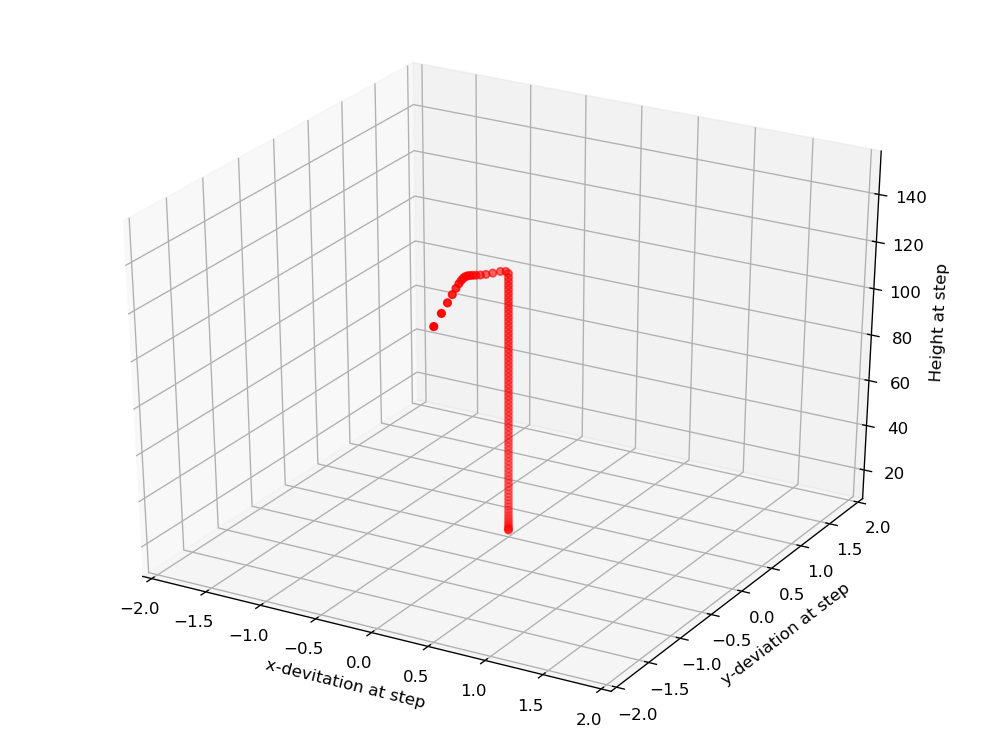

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6), dpi=120)
ax = Axes3D(fig)

ax.scatter(x, y, z, c='r')

ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(10,155)
ax.set_xlabel('x-devitation at step')
ax.set_ylabel('y-deviation at step')
ax.set_zlabel('Height at step')

plt.show()

In [25]:
#import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

steps = list(range(0, (len(t.traces[-1].rewards)), 1))
height = z

trace = go.Scatter(
    x = steps,
    y = height
)

data = [trace]

iplot(data)

In [26]:
trace = go.Scatter3d(
    x=x, y=y, z=z,
    marker=dict(
        size=4,
        color=z,
        colorscale='Viridis',
    ),
    line=dict(
        color='#1f77b4',
        width=1
    )
)

data = [trace]

layout = dict(
    width=800,
    height=700,
    autosize=False,
    title='Drone takeoff',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            #range = [-.01,.01]
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            #range = [-.01,.01]
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            #range = [10,160]
        ),
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=-1.7428,
                y=1.0707,
                z=0.7100,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)

fig = dict(data=data, layout=layout)

iplot(fig)